# TDC 101: Basics

[Kexin](https://twitter.com/KexinHuang5)

Welcome to the TDC community! In this first tutorial, we will cover the basics of TDC and after this tutorial, you will be able to access all of the TDC datasets!

### What is TDC?

Therapeutics Data Commons (TDC) is an open and extensive data hub that includes 50+ machine learning (ML) ready datasets across 20+ therapeutic tasks, ranging from target discovery, activity screening, efficacy, safety to manufacturing, covering small molecule, antibodies, miRNA and other therapeutics products.

TDC mainly consists of two parts: the first core part is the datasets loaders where you can get the ML ready data; and the second part is the data functions where we provide numerous functions to help process the data, evaluate the ML models, etc. Let's get started!

### Installation

The core TDC library only relies on a few lightweight packages: pandas, scikit-learn, numpy, fuzzywuzzy, tqdm. For some specific use case requiring other packages, we provide instructions when you use it. To install TDC, simply type:

```bash
pip install PyTDC
```

Now, you have TDC installed! We can get started to introduce the dataset loader! 

TDC covers a wide range of therapeutics tasks with varying data structures. Thus, we organize it into three layers of hierarchies. First, we divide into three distinctive machine learning **problems**:

* Single-instance prediction `single_pred`: Prediction of property given individual biomedical entity.
* Multi-instance prediction `multi_pred`: Prediction of property given multiple biomedical entities. 
* Generation `generation`: Generation of new biomedical entity.

The second layer is **task**. Each therapeutic task falls into one of the machine learning problem. We create a data loader class for every *task* that inherits from the base problem data loader. 

The last layer is **dataset**, where each task consists of many of them. As the data structure of most datasets in a task is the same, the dataset is used as a function input to the task data loader.

Supposed a dataset X is from therapeutic task Y with machine learning problem Z, then to obtain the data and splits, simply type:

```python
from tdc.Z import Y
data = Y(name = 'X')
split = data.split()
```
For example, to obtain the Caco2 dataset from ADME therapeutic task in the single-instance prediction problem:

In [2]:
from tdc.single_pred import ADME
data = ADME(name = 'Caco2_Wang')

Downloading...
100%|██████████| 84.3k/84.3k [00:00<00:00, 952kiB/s]
Loading...
Done!


The object `data` is a data loader class, which contains various functions. Note that as many dataset names are complicated with cases and stuff, in the backend, TDC supports fuzzy search, so you don't need to worry about typing wrong a few characters!

You can then split the dataset into training, validation and testing pandas data frames, processed in ML ready format:

In [3]:
split = data.get_split()
split['train'].head(2)

,Drug_ID,Drug,Y
0,(-)-epicatechin,O1c2c(CC(O)C1c1cc(O)c(O)cc1)c(O)cc(O)c2,-6.22
1,"(2E,4Z,8Z)-N-isobutyldodeca-2,4,10-triene-8 -y...",O=C(NCC(C)C)\C=C\C=C/CCC#C\C=C/C,-3.86


You can specify the splitting method, random seed, and split fractions in the function by e.g. `data.get_split(method = 'random', seed = 1, frac = [0.7, 0.1, 0.2])`. In default, the split `method` is random split, the `seed` is the TDC benchmark seed (`seed = 'benchmark'`), and the fraction `frac` is 70%, 10%, 20% for training, validation and testing.

We provide various data functions, for example, you can visualize the label distribution:

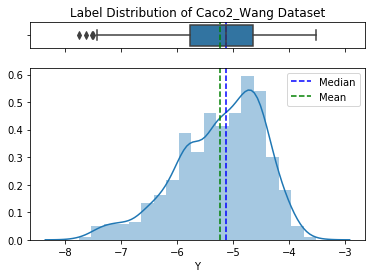

The median is -5.131223899999999
The mean is -5.239498353736264


In [4]:
data.label_distribution()

You can also binarize the data if you want to do binary classification instead. For example, for Caco-2, we know higher than -4.7 is good, so we can do binarization by typing:

The data is already binarized!


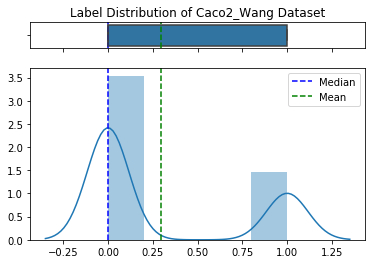

The median is 0.0
The mean is 0.2934065934065934


In [6]:
data.binarize(threshold = -4.7, order = 'ascending')
data.label_distribution()

In [11]:
from tdc.multi_pred import PeptideMHC
data = PeptideMHC(name = 'MHC1_IEDB-IMGT_Nielsen')
split = data.get_split()

Downloading...
100%|██████████| 15.1M/15.1M [00:02<00:00, 6.30MiB/s]
Loading...
Done!


In [12]:
from tdc.single_pred import Epitope
data = Epitope(name = 'iedb_jespersen')

Found local copy...
Loading...
Done!


In [13]:
from tdc.multi_pred import DTI
data = DTI(name = 'davis')
split = data.get_split()

Found local copy...
Loading...
Done!


In [17]:
from tdc.multi_pred import PPI
data = PPI(name = 'HuRI')

Downloading...
100%|██████████| 139M/139M [00:08<00:00, 16.9MiB/s] 
Loading...
Done!


In [3]:
from tdc.multi_pred import DrugRes
data = DrugRes(name = 'GDSC1')
split = data.get_split()

Downloading...
100%|██████████| 140M/140M [00:07<00:00, 20.0MiB/s] 
Loading...
Done!


In [1]:
from tdc.utils import retrieve_label_name_list
label_list = retrieve_label_name_list('qm9')

In [1]:
from tdc.single_pred import QM
data = QM(name = 'qm7b', label_name = 'E_PBE0')

Tip: Use tdc.utils.retrieve_label_name_list('qm7b') to retrieve all available label names.
Downloading...
100%|██████████| 16.4M/16.4M [00:01<00:00, 14.0MiB/s]
Loading...
Done!


In [2]:
from tdc.single_pred import QM
data = QM(name = 'qm9', label_name = label_list[2])

Downloading...
100%|██████████| 922M/922M [00:38<00:00, 24.0MiB/s] 
Loading...
Done!


In [1]:
from tdc.single_pred import Develop
data = Develop(name = 'TAP', label_name = 'PNC')
split = data.get_split()

Found local copy...
Loading...
Done!


In [5]:
from tdc.single_pred import Develop
data = Develop(name = 'SAbDab_Chen')
split = data.get_split()

Downloading...
100%|██████████| 601k/601k [00:00<00:00, 1.48MiB/s]
Loading...
Done!


In [1]:
from tdc.multi_pred import AntibodyAff
data = AntibodyAff(name = 'Protein_SAbDab')
split = data.get_split()

Downloading...
100%|██████████| 330k/330k [00:00<00:00, 1.05MiB/s]
Loading...
Done!


In [1]:
from tdc.multi_pred import DrugSyn
data = DrugSyn(name = 'OncoPolyPharmacology')
split = data.get_split()

Found local copy...
Loading...
Done!


In [5]:
from tdc.multi_pred import GDA
data = GDA(name = 'DisGeNET')
data.print_stats()

Found local copy...
Loading...
Done!
--- Dataset Statistics ---
7399 unique genes.
7095 unique diseases.
52476 gene-disease pairs.
--------------------------


In [3]:
from tdc.multi_pred import MTI
data = MTI(name = 'miRTarBase')
split = data.get_split(method = 'cold_split', column_name = 'miRNA')

Downloading...
100%|██████████| 338M/338M [00:15<00:00, 22.6MiB/s] 
Loading...
Done!


In [2]:
data = data.neg_sample(frac = 1)

In [4]:
len(data.get_data())

1048028

In [14]:
from tdc.multi_pred import GDA
data = GDA(name = 'DisGeNET')
split = data.get_split()

Downloading...
100%|██████████| 63.9M/63.9M [00:03<00:00, 20.2MiB/s]
Loading...
Done!


In [1]:
from tdc.single_pred import Paratope
data = Paratope(name = 'SAbDab_Liberis')
split = data.get_split()

Downloading...
100%|██████████| 150k/150k [00:00<00:00, 712kiB/s] 
Loading...
Done!


In [2]:
len(data.get_data())

1023

In [1]:
from tdc.multi_pred import DTI
data = DTI(name = 'DAVIS')
split = data.get_split(method = 'cold_split', column_name = 'Drug')

Found local copy...
Loading...
Done!


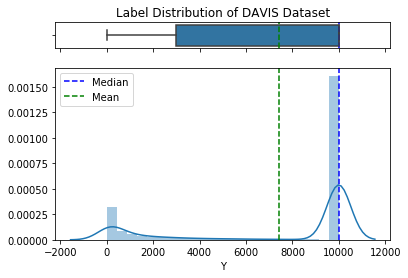

The median is 10000.0
The mean is 7415.876611724781


In [2]:
data.label_distribution()

In [3]:
data.binarize(threshold = 30, order = 'descending')

Binariztion using threshold 30, default, we assume the smaller values are 1 and larger ones is 0, you can change the order by 'binarize(order = 'ascending')'


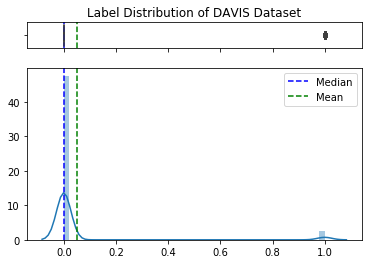

The median is 0.0
The mean is 0.050106467926537133


In [4]:
data.label_distribution()

In [29]:
from tdc.single_pred import HTS
data = HTS(name = 'SARSCoV2_3CLPro_Diamond')

Downloading...
100%|██████████| 30.9k/30.9k [00:00<00:00, 7.47MiB/s]
Loading...
Done!


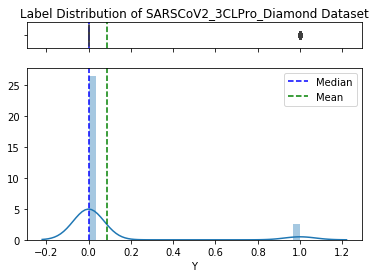

The median is 0.0
The mean is 0.08863636363636364


In [30]:
data.label_distribution()

In [31]:
len(data)

880

In [32]:
data.balanced(oversample = True, seed = 'benchmark')

 Oversample of minority class is used. 


,Drug_ID,Drug,Y
0,47,OC=1C=CC=CN1,1
1,856,C[1C@@H]1CC[1C@@H](O1)C(=O)N2CCC=C(F)C2,0
2,494,CC1CCCCN1CCN,0
3,74,ClCC(=O)Nc1cccnc1Cl,1
4,54,CC(=O)NC(Cc1ccc(cc1)O)C(=O)NCC#CBr,1
...,...,...,...
1599,504,CC(=O)NCC1=NC=CN1,0
1600,353,ClCC(=O)N1CCN(CC1)C2CCS(=O)(=O)C2,0
1601,594,NC(=O)CN1CCN(CC1)C(=O)C2=CC=CO2,0
1602,71,ClCC(=O)NCc1ccc2OCOc2c1,1


In [1]:
from tdc.multi_pred import DTI
data = DTI(name = 'DAVIS')
out = data.to_graph(threshold = 30, format = 'dgl', split = True, frac = [0.7, 0.1, 0.2], seed = 'benchmark', order = 'descending')

Downloading...
100%|██████████| 26.7M/26.7M [00:03<00:00, 8.78MiB/s]
Loading...
Done!
The dataset label consists of affinity scores. Binarization using threshold 30 is conducted to construct the positive edges in the network. Adjust the threshold by to_graph(threshold = X)
Using backend: pytorch


In [13]:
out.keys()

dict_keys(['dgl_graph', 'index_to_entities', 'split'])

In [14]:
from tdc.multi_pred import PPI
data = PPI(name = 'HuRI')
data = data.neg_sample(frac = 1)

Downloading...
100%|██████████| 139M/139M [00:06<00:00, 20.0MiB/s] 
Loading...
Done!


In [3]:
from tdc import Evaluator

evaluator = Evaluator(name = 'ROC-AUC')
print(evaluator([0,1], [0.5, 0.6]))

1.0


In [1]:
from tdc import Oracle

oracle = Oracle(name = 'Uniqueness')

smiles_lst = ['CC(C)(C)[C@H]1CCc2c(sc(NC(=O)COc3ccc(Cl)cc3)c2C(N)=O)C1', \
			  'C[C@@H]1CCc2c(sc(NC(=O)c3ccco3)c2C(N)=O)C1', \
			  'CCNC(=O)c1ccc(NC(=O)N2CC[C@H](C)[C@H](O)C2)c(C)c1', \
			  'C[C@@H]1CCN(C(=O)CCCc2ccccc2)C[C@@H]1O']

print(oracle(smiles_lst))

[0.05454545454545454, 0.07142857142857142, 0.061224489795918366, 0.07894736842105263]


In [1]:
from tdc import Oracle

oracle = Oracle(name = 'Novelty')

smiles_lst = ['CC(C)(C)[C@H]1CCc2c(sc(NC(=O)COc3ccc(Cl)cc3)c2C(N)=O)C1', \
			  'C[C@@H]1CCc2c(sc(NC(=O)c3ccco3)c2C(N)=O)C1', \
			  'CCNC(=O)c1ccc(NC(=O)N2CC[C@H](C)[C@H](O)C2)c(C)c1', \
			  'C[C@@H]1CCN(C(=O)CCCc2ccccc2)C[C@@H]1O']

print(oracle(smiles_lst, smiles_lst))

0.0


In [2]:
from tdc.utils import cid2smiles
smiles = cid2smiles(2248631)

In [3]:
smiles

'CCOC1=CC(=C(C=C1C=CC(=O)O)Br)OCC'

In [1]:
from tdc.utils import uniprot2seq
seq = uniprot2seq('P49122')

In [2]:
seq

'MKTLLLTLVVVTIVCLDLGYTLKCHNTQLPFIYNTCPEGKNLCFKATLKFPLKFPVKRGCAATCPRSSSLVKVVCCKTDKCN'

In [2]:
y_true = [[0, 1], [1, 1, 0, 1]]
y_pred = [[0.3, 0.2], [0.9, 0.89, 0.1, 0.8]]

In [27]:
from tdc import Evaluator
evaluator = Evaluator(name = 'R2')
score = evaluator(y_true[0], y_pred[0], threshold = 0.1)

In [28]:
score

-0.4600000000000002

In [5]:
from tdc.utils import name2id
list(name2id.keys())

['bbb_adenot',
 'bbb_martins',
 'bindingdb_ic50',
 'bindingdb_kd',
 'bindingdb_ki',
 'bioavailability_ma',
 'caco2_wang',
 'clearance_edrug3d',
 'clintox',
 'cyp1a2_veith',
 'cyp2c19_veith',
 'cyp2c9_veith',
 'cyp2d6_veith',
 'cyp3a4_veith',
 'davis',
 'drugbank',
 'f20_edrug3d',
 'f30_edrug3d',
 'halflife_edrug3d',
 'hia_hou',
 'hiv',
 'huri',
 'hydrationfreeenergy_freesolv',
 'kiba',
 'lipophilicity_astrazeneca',
 'pgp_broccatelli',
 'ppbr_edrug3d',
 'ppbr_ma',
 'sarscov2_3clpro_diamond',
 'sarscov2_vitro_touret',
 'solubility_aqsoldb',
 'tox21',
 'toxcast',
 'twosides',
 'vd_edrug3d',
 'mhc1_iedb-imgt_nielsen',
 'mhc2_iedb_jensen',
 'zinc',
 'moses',
 'chembl',
 'qed',
 'drd2',
 'logp',
 'gdsc1',
 'gdsc2',
 'iedb_jespersen',
 'pdb_jespersen',
 'qm7b',
 'qm8',
 'qm9',
 'tap',
 'sabdab_chen',
 'protein_sabdab',
 'oncopolypharmacology',
 'mirtarbase',
 'disgenet',
 'sabdab_liberis',
 'uspto50k',
 'buchwald-hartwig',
 'uspto_yields',
 'uspto_catalyst',
 'uspto_reaction']

In [2]:
from tdc.multi_pred import Catalyst
data = Catalyst(name = 'USPTO_Catalyst')
split = data.get_split()

Downloading...
100%|██████████| 565M/565M [00:28<00:00, 19.8MiB/s] 
Loading...
Done!


In [6]:
len(data)

1257015

In [3]:
data.get_split()['valid'].head(2)

,Reactant_ID,Reactant,Product_ID,Product,Y
0,reactant_636679,Br[C:2]1[N:3]=[CH:4][C:5]2[N:6]([C:8]([C:11]3[...,product_599114,[F:18][C:19]1[CH:24]=[CH:23][C:22]([C:25]2[O:2...,75
1,reactant_113841,C(N(CC)CC)C.[C:8]([O:12][C:13](=[O:19])[C@H:14...,product_109153,[C:8]([O:12][C:13](=[O:19])[C@H:14]([CH:16]([C...,85


In [7]:
from tdc.utils import get_label_map
d = get_label_map(name = 'USPTO_Catalyst', task = 'Catalyst')
len(d)

888

In [16]:
from tdc.single_pred import Yields
data = Yields(name = 'Buchwald-Hartwig')
split = data.get_split()

Found local copy...
Loading...
Done!


In [17]:
len(data)

55370

In [12]:
df = data.get_data()
df.Reaction.values[0]['reactant']

'FC(F)(F)c1ccc(Cl)cc1.Cc1ccc(N)cc1.O=S(=O)(O[Pd]1c2ccccc2-c2ccccc2N~1)C(F)(F)F.CC(C)c1cc(C(C)C)c(-c2ccccc2P(C2CCCCC2)C2CCCCC2)c(C(C)C)c1.CCN=P(N=P(N(C)C)(N(C)C)N(C)C)(N(C)C)N(C)C.c1ccc(-c2ccno2)cc1'

In [13]:
from tdc.single_pred import Yields
data = Yields(name = 'USPTO_Yields')
split = data.get_split()

Downloading...
100%|██████████| 407M/407M [00:19<00:00, 20.7MiB/s] 
Loading...
Done!


In [14]:
df = data.get_data()
df.Reaction.values[0]['reactant']

'[Cl-].[Al+3].[Cl-].[Cl-].[Cl:5][CH2:6][CH2:7][CH2:8][C:9](Cl)=[O:10].[C:12]1([CH:18]([CH3:20])[CH3:19])[CH:17]=[CH:16][CH:15]=[CH:14][CH:13]=1'

In [15]:
len(df)

853638

In [3]:
from tdc.generation import PairMolGen
data = PairMolGen(name = 'LogP')
split = data.get_split()

Downloading...
100%|██████████| 9.38M/9.38M [00:01<00:00, 8.29MiB/s]
Loading...
Done!


In [4]:
split['train']

,X,Y
0,c1ccc(-c2noc(CCCn3cc[nH+]c3)n2)cc1,O=C(NCCc1nc(-c2ccccc2)no1)C(c1ccccc1)c1ccccc1
1,C[C@H]1C[C@@H](C)C[NH+](CCCCNC(=O)c2ccc(F)cc2C...,O=C(Nc1ccccc1C(=O)NC1CC1)c1ccc(F)cc1Cl
2,Cc1ccc([C@H](C)NC(=O)N[C@@](C)(C(=O)[O-])C(F)(...,Cc1ccc([C@@H](C)NC(=O)c2c(Cl)cccc2Cl)o1
3,Cc1cc(CN2CCN(C(=O)c3ccc([O-])nn3)CC2)on1,Cc1cc(C(=O)N2CCN(Cc3ccc(-c4cccc(Cl)c4)s3)CC2)on1
4,C[NH2+][C@@]1(C(N)=O)CCC[C@@H]1CCSc1nc(C)n[nH]1,Cc1n[nH]c(SCCC(=O)N2CCCC2)n1
...,...,...
69931,C[C@H]([NH2+][C@H]1CCCS[C@H]1C)c1cccnc1,C[C@@H](NC(=O)[C@@H]1CCCS1)c1ccc(-c2cccnc2)cc1
69932,O=C(CCCc1nc(-c2ccccc2)no1)N[C@H]1CCS(=O)(=O)C1,CCc1ccccc1NC(=O)CCCc1nc(-c2ccc(C)cc2)no1
69933,COc1ccccc1[C@@H](CNC(=O)NC[C@@]1(O)CCCc2ccccc2...,O=C(NC[C@]1(O)CCCc2ccccc21)Nc1ccc(F)cc1F
69934,COc1ccc([C@@H]2CCCCCN2C(=O)C[NH+]2CCc3sccc3C2)cc1,COc1ccc([C@H]2CCCN2C(=O)Cc2ccc(Cl)cc2)cc1


In [1]:
from tdc.generation import RetroSyn
data = RetroSyn(name = 'USPTO')
split = data.get_split()

Found local copy...
Loading...
Done!


In [2]:
len(data)

1939253

In [3]:
from tdc.generation import Reaction
data = Reaction(name = 'USPTO')
split = data.get_split()

Found local copy...
Loading...
Done!


In [1]:
from tdc.generation import RetroSyn
data = RetroSyn(name = 'USPTO50K')
split = data.get_split()

Downloading...
100%|██████████| 5.22M/5.22M [00:01<00:00, 4.58MiB/s]
Loading...
Done!


In [28]:
from tdc.utils import retrieve_label_name_list
label_list = retrieve_label_name_list('Toxcast')

In [30]:
from tdc.single_pred import Tox
data = Tox(name = 'ToxCast', label_name = label_list[0])
split = data.get_split()

Downloading...
100%|██████████| 10.4M/10.4M [00:01<00:00, 6.00MiB/s]
Loading...
Done!


In [32]:
from tdc.single_pred import HTS
data = HTS(name = 'SARSCoV2_Vitro_Touret')
split = data.get_split()

Downloading...
100%|██████████| 101k/101k [00:00<00:00, 612kiB/s] 
Loading...
Done!


In [33]:
from tdc.metadata import versioning

In [35]:
len(versioning['0.0.1'])

62

In [2]:
from tdc.generation import RetroSyn
data = RetroSyn(name = 'USPTO-50K')
from tdc.utils import get_reaction_type
get_reaction_type('USPTO-50K')

Found local copy...
Loading...
Done!


array([1, 4, 2, ..., 3, 1, 4])

In [3]:
from tdc.single_pred import HTS
data = HTS(name = 'SARSCoV2_Vitro_Touret')
data = data.get_data(format = 'dict')
data['Drug_ID']

Downloading...
100%|██████████| 101k/101k [00:00<00:00, 642kiB/s] 
Loading...
Done!


array([   0,    1,    2, ..., 1481, 1482, 1483])